# Importation Data

In [1]:
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn import metrics
import plotly.express as px
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras_tuner import RandomSearch
from pathlib import Path
from tensorflow.keras import  mixed_precision, layers

In [2]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("CPU devices:", tf.config.list_physical_devices('CPU'))
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# Mixed precision (gain VRAM + vitesse si GPU récent)
mixed_precision.set_global_policy('mixed_float16')

# Optional: limiter verbosité TF
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

TF version: 2.20.0
CPU devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU devices: []


In [3]:
daily_data = pd.DataFrame()
data_SP500 = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_SP500.parquet')
data_NDX = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_NASDAQ.parquet')
data_MP = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_MP.parquet')
data_Crypto = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_Crypto.parquet')
data_SmallCap_US = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_SmallCap_US.parquet')
data_MidCap_US = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_MidCap_US.parquet')
data_LargeCap_Chine = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_LargeCap_Chine.parquet')
daily_data = pd.concat([data_SP500, data_NDX, data_MP, data_Crypto, data_SmallCap_US, data_MidCap_US, data_LargeCap_Chine], ignore_index=True)
daily_data = daily_data.drop_duplicates(subset=['Ticker', 'Date'])
daily_data

Price,Date,Close,High,Low,Open,Volume,Ticker,Adj Close
0,1976-07-01,0.359528,0.362539,0.359528,0.359528,729000.0,PEP,NaN
1,1976-07-01,1.112835,1.134022,1.108375,1.134022,691200.0,TXN,NaN
2,1976-07-01,0.874979,0.874979,0.838951,0.838951,21600.0,VMC,NaN
3,1976-07-01,0.423837,0.428162,0.418791,0.418791,2320272.0,MRK,NaN
4,1976-07-01,0.113854,0.117365,0.113854,0.117365,2615606.0,PFE,NaN
...,...,...,...,...,...,...,...,...
10592466,2025-09-11,6.830000,6.840000,6.730000,6.820000,146290475.0,000002.SZ,NaN
10592467,2025-09-12,6.940000,7.140000,6.830000,6.830000,322089159.0,000002.SZ,NaN
10592468,2025-09-15,6.970000,7.040000,6.820000,6.920000,228923025.0,000002.SZ,NaN
10592469,2025-09-16,7.040000,7.050000,6.890000,6.950000,222680538.0,000002.SZ,NaN


In [4]:
data_SP500

Price,Date,Close,High,Low,Open,Volume,Ticker,Adj Close
index,,,,,,,,
2688159,1976-07-01,0.359528,0.362539,0.359528,0.359528,729000.0,PEP,NaN
3410451,1976-07-01,1.112835,1.134022,1.108375,1.134022,691200.0,TXN,NaN
3546708,1976-07-01,0.874979,0.874979,0.838951,0.838951,21600.0,VMC,NaN
2352312,1976-07-01,0.423837,0.428162,0.418791,0.418791,2320272.0,MRK,NaN
2700562,1976-07-01,0.113854,0.117365,0.113854,0.117365,2615606.0,PFE,NaN
...,...,...,...,...,...,...,...,...
340,2025-10-06,132.210007,133.919998,130.570007,133.250000,800900.0,NTRS,NaN
341,2025-10-06,135.589996,138.529999,135.559998,137.990005,1158100.0,NUE,NaN
342,2025-10-06,185.539993,187.229996,183.330002,185.500000,156436000.0,NVDA,NaN


In [5]:
#start_date = "1990-01-03"
#final_date = "2025-07-16"

daily_data = daily_data.sort_values(by=['Date'], ascending = True)

# Accéder à l'index de la colonne 'Date'
#s = daily_data[daily_data['Date'] == start_date].index[0]
#f = daily_data[daily_data['Date'] == final_date].index[0]

# Filtrer les données à partir de la date spécifiée
#daily_data = daily_data.loc[s:]

daily_data

Price,Date,Close,High,Low,Open,Volume,Ticker,Adj Close
4337086,1962-01-02,0.646239,0.650278,0.642200,0.642200,5.123300e+04,XRX,NaN
10255469,1962-01-02,1.479799,1.488287,1.479799,1.479799,5.593000e+04,AA,NaN
10255470,1962-01-03,1.502435,1.502435,1.476970,1.479800,7.490600e+04,AA,NaN
4337087,1962-01-03,0.658355,0.658355,0.650278,0.650278,5.123300e+04,XRX,NaN
10255471,1962-01-04,1.502435,1.513753,1.502435,1.502435,8.089900e+04,AA,NaN
...,...,...,...,...,...,...,...,...
4262343,2025-10-07,3986.600098,4000.100098,3963.399902,3983.000000,1.227000e+05,GC=F,NaN
4274952,2025-10-07,61.669998,62.040001,61.270000,61.730000,4.038300e+04,CL=F,NaN
4306823,2025-10-07,2.973836,2.998861,2.960505,2.990715,6.479801e+09,XRP-USD,NaN
4312603,2025-10-07,1298.236938,1298.605469,1209.572266,1223.624146,6.926119e+09,BNB-USD,NaN


In [6]:
#Date au format Date
daily_data['Date'] = pd.to_datetime(daily_data['Date'])

# Définir la colonne 'Date' comme index
daily_data.set_index('Date', inplace=True)

daily_data

Price,Close,High,Low,Open,Volume,Ticker,Adj Close
Date,,,,,,,
1962-01-02,0.646239,0.650278,0.642200,0.642200,5.123300e+04,XRX,NaN
1962-01-02,1.479799,1.488287,1.479799,1.479799,5.593000e+04,AA,NaN
1962-01-03,1.502435,1.502435,1.476970,1.479800,7.490600e+04,AA,NaN
1962-01-03,0.658355,0.658355,0.650278,0.650278,5.123300e+04,XRX,NaN
1962-01-04,1.502435,1.513753,1.502435,1.502435,8.089900e+04,AA,NaN
...,...,...,...,...,...,...,...
2025-10-07,3986.600098,4000.100098,3963.399902,3983.000000,1.227000e+05,GC=F,NaN
2025-10-07,61.669998,62.040001,61.270000,61.730000,4.038300e+04,CL=F,NaN
2025-10-07,2.973836,2.998861,2.960505,2.990715,6.479801e+09,XRP-USD,NaN


In [7]:

# Rééchantillonner les données en fréquence Annuelle
yearly_data = daily_data.groupby("Ticker").resample('YE').agg({
    'Open': 'first',   # Premier prix d'ouverture du mois
    'High': 'max',     # Plus haut du mois
    'Low': 'min',      # Plus bas du mois
    'Close': 'last',   # Dernier prix de clôture du mois
    'Volume': 'sum',   # Somme du volume sur le mois
}).reset_index()
yearly_data

Price,Ticker,Date,Open,High,Low,Close,Volume
0,000002.SZ,1991-12-31,0.136292,0.167421,0.044994,0.129228,1.679247e+09
1,000002.SZ,1992-12-31,0.128705,0.455805,0.114056,0.445760,9.160604e+09
2,000002.SZ,1993-12-31,0.449527,0.459572,0.238731,0.338753,9.247587e+09
3,000002.SZ,1994-12-31,0.338753,0.344414,0.113719,0.155781,8.603484e+09
4,000002.SZ,1995-12-31,0.149809,0.184340,0.106398,0.107632,1.607695e+09
...,...,...,...,...,...,...,...
41200,ZYME,2021-12-31,48.000000,59.029999,14.900000,16.389999,1.347241e+08
41201,ZYME,2022-12-31,16.490000,17.270000,4.110000,7.860000,3.245733e+08
41202,ZYME,2023-12-31,7.950000,10.990000,6.015000,10.390000,1.397208e+08
41203,ZYME,2024-12-31,10.260000,17.700001,7.970000,14.640000,1.532948e+08


In [8]:

# Rééchantillonner les données en fréquence mensuelle
monthly_data = daily_data.groupby("Ticker").resample('ME').agg({
    'Open': 'first',   # Premier prix d'ouverture du mois
    'High': 'max',     # Plus haut du mois
    'Low': 'min',      # Plus bas du mois
    'Close': 'last',   # Dernier prix de clôture du mois
    'Volume': 'sum',   # Somme du volume sur le mois
}).reset_index()
monthly_data


Price,Ticker,Date,Open,High,Low,Close,Volume
0,000002.SZ,1991-01-31,0.136292,0.136292,0.126525,0.126525,2821642.0
1,000002.SZ,1991-02-28,0.126525,0.133675,0.126525,0.131583,39996433.0
2,000002.SZ,1991-03-31,0.130885,0.130885,0.114928,0.114928,18016405.0
3,000002.SZ,1991-04-30,0.114928,0.114928,0.101586,0.101586,5366110.0
4,000002.SZ,1991-05-31,0.101586,0.101586,0.095831,0.098447,74809688.0
...,...,...,...,...,...,...,...
480874,ZYME,2025-05-31,12.950000,13.230000,10.860000,11.430000,9389500.0
480875,ZYME,2025-06-30,11.500000,13.435000,11.320000,12.550000,10303500.0
480876,ZYME,2025-07-31,12.450000,15.000000,12.160000,12.560000,8788100.0
480877,ZYME,2025-08-31,12.400000,15.380000,11.510000,14.810000,9711700.0


In [9]:

# Rééchantillonner les données en fréquence semestrielle
weekly_data = daily_data.groupby("Ticker").resample('W').agg({
    'Open': 'first',   # Premier prix d'ouverture du mois
    'High': 'max',     # Plus haut du mois
    'Low': 'min',      # Plus bas du mois
    'Close': 'last',   # Dernier prix de clôture du mois
    'Volume': 'sum',   # Somme du volume sur le mois
}).reset_index()
weekly_data


Price,Ticker,Date,Open,High,Low,Close,Volume
0,000002.SZ,1991-01-06,0.136292,0.136292,0.133501,0.133501,1679683.0
1,000002.SZ,1991-01-13,0.134896,0.134896,0.132106,0.132106,615328.0
2,000002.SZ,1991-01-20,0.130711,0.130711,0.128269,0.128269,194021.0
3,000002.SZ,1991-01-27,0.128269,0.128269,0.128269,0.128269,0.0
4,000002.SZ,1991-02-03,0.128269,0.128269,0.126525,0.126525,332610.0
...,...,...,...,...,...,...,...
2085138,ZYME,2025-08-24,14.370000,15.380000,13.480000,15.100000,1817300.0
2085139,ZYME,2025-08-31,15.110000,15.350000,14.540000,14.810000,2118200.0
2085140,ZYME,2025-09-07,13.910000,15.280000,13.600000,15.050000,2398500.0
2085141,ZYME,2025-09-14,15.000000,16.370001,14.690000,15.740000,2512100.0


# Labelling

In [10]:
daily_data = daily_data.reset_index()

### Target Pourcentage

In [11]:
def Best_And_Worst_Stocks_Pourcentage(snp_prices, pourcentage, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Performance'])

    # Ajouter l'année cible (année suivante car performance à horizon futur)
    snp_prices_copy['Year'] = snp_prices_copy['Date'].dt.year
    snp_prices_copy['Month'] = snp_prices_copy['Date'].dt.month

    top_stocks = snp_prices_copy[snp_prices_copy['Performance'] > pourcentage]
    flop_stocks = snp_prices_copy[snp_prices_copy['Performance'] < pourcentage]

    # Sélection finale
    top_stocks = top_stocks[['Month','Year', 'Ticker', 'Performance']]
    print(top_stocks)
    flop_stocks = flop_stocks[['Month', 'Year', 'Ticker', 'Performance']]

    return top_stocks, flop_stocks

In [12]:
def Merge_Performance_Pourcentage(snp, data, window, pourcentage):
    # Obtenir les top et flop stocks
    top_stocks, flop_stocks = Best_And_Worst_Stocks_Pourcentage(data, pourcentage, window)

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])
    snp['Year'] = snp['Date'].dt.year
    snp['Month'] = snp['Date'].dt.month
    #snp['Year'] = snp.apply(lambda row: row['Year'] + 1 if row['Date'].month == 12 else row['Year'], axis=1)

    # Fusionner avec top et flop
    snp = snp.sort_values(by=['Ticker', 'Year', 'Month'])
    top_stocks = top_stocks.sort_values(by=['Ticker', 'Year', 'Month'])
    flop_stocks = flop_stocks.sort_values(by=['Ticker', 'Year', 'Month'])

    # Marquage top
    snp = pd.merge(snp, top_stocks, on=['Ticker', 'Year', 'Month'], how='left', suffixes=('', '_top'))
    snp['Top_Label'] = (snp['Performance'] > 0).astype(int)
    snp = snp.drop(columns=['Performance'])

    # Marquage flop
    snp = pd.merge(snp, flop_stocks, on=['Ticker', 'Year', 'Month'], how='left', suffixes=('', '_flop'))
    snp['Flop_Label'] = (snp['Performance'] < 0).astype(int)
    snp = snp.drop(columns=['Performance'])

    return snp

### Top Momentum ajusted Vol

In [13]:
def Best_And_Worst_Stocks_Momentum_Ajusted_Vol_Years(snp_prices, top_n, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    #Calcul du rendement par année glissante
    snp_prices_copy['Return'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Calcul de la volatilité glissante
    snp_prices_copy["Vol"] = snp_prices_copy.groupby('Ticker')['Return'].rolling(window).std().reset_index(level=0, drop=True)
    # Calcul du Momentum Vol Ajusted
    snp_prices_copy['Momentum Ajusted Vol'] = snp_prices_copy['Performance'] / snp_prices_copy['Vol']
    print(snp_prices_copy)

    # Replace infinite updated data with nan
    snp_prices_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Momentum Ajusted Vol'])


    # Ajouter l'année cible (année suivante car performance à horizon futur)
    snp_prices_copy['Year'] = snp_prices_copy['Date'].dt.year
    #snp_prices_copy['Month'] = snp_prices_copy['Date'].dt.month

    # Trier par Date et Performance descendante pour top, ascendante pour flop
    sorted_df = snp_prices_copy.sort_values(by=['Date', 'Momentum Ajusted Vol'], ascending=[True, False])
    top_stocks = sorted_df.groupby('Date').head(top_n)

    sorted_df_flop = snp_prices_copy.sort_values(by=['Date', 'Momentum Ajusted Vol'], ascending=[True, True])
    flop_stocks = sorted_df_flop.groupby('Date').head(top_n)

    # Sélection finale
    top_stocks = top_stocks[['Year', 'Ticker', 'Momentum Ajusted Vol']]
    flop_stocks = flop_stocks[['Year', 'Ticker', 'Momentum Ajusted Vol']]

    return top_stocks, flop_stocks

In [14]:
def Merge_Performance_Years_Top_Momentum_Ajusted_Vol(snp, data, window, top_n):
    # Obtenir les top et flop stocks
    top_stocks, flop_stocks = Best_And_Worst_Stocks_Momentum_Ajusted_Vol_Years(data, top_n, window)

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])
    snp['Year'] = snp['Date'].dt.year
    #snp['Month'] = snp['Date'].dt.month
    #snp['Year'] = snp.apply(lambda row: row['Year'] + 1 if row['Date'].month == 12 else row['Year'], axis=1)

    # Fusionner avec top et flop
    snp = snp.sort_values(by=['Ticker', 'Year'])
    top_stocks = top_stocks.sort_values(by=['Ticker', 'Year'])
    flop_stocks = flop_stocks.sort_values(by=['Ticker', 'Year'])

    # Marquage top
    snp = pd.merge(snp, top_stocks, on=['Ticker', 'Year'], how='left', suffixes=('', '_top'))
    snp['Top_Label'] = (snp['Momentum Ajusted Vol'] > 0).astype(int)
    snp = snp.drop(columns=['Momentum Ajusted Vol'])

    # Marquage flop
    snp = pd.merge(snp, flop_stocks, on=['Ticker', 'Year'], how='left', suffixes=('', '_flop'))
    snp['Flop_Label'] = (snp['Momentum Ajusted Vol'] < 0).astype(int)
    snp = snp.drop(columns=['Momentum Ajusted Vol'])

    return snp

### Target Top

In [15]:
def Best_And_Worst_Stocks_Years(snp_prices, top_n, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Performance'])

    # Ajouter l'année cible (année suivante car performance à horizon futur)
    snp_prices_copy['Year'] = snp_prices_copy['Date'].dt.year
    snp_prices_copy['Month'] = snp_prices_copy['Date'].dt.month

    # Trier par Date et Performance descendante pour top, ascendante pour flop
    sorted_df = snp_prices_copy.sort_values(by=['Date', 'Performance'], ascending=[True, False])
    top_stocks = sorted_df.groupby('Date').head(top_n)

    sorted_df_flop = snp_prices_copy.sort_values(by=['Date', 'Performance'], ascending=[True, True])
    flop_stocks = sorted_df_flop.groupby('Date').head(top_n)

    # Sélection finale
    top_stocks = top_stocks[['Month', 'Year', 'Ticker', 'Performance']]
    flop_stocks = flop_stocks[['Month', 'Year', 'Ticker', 'Performance']]
    print(top_stocks)

    return top_stocks, flop_stocks

In [16]:
def Merge_Performance_Years_Top(snp, data, window, top_n):
    # Obtenir les top et flop stocks
    top_stocks, flop_stocks = Best_And_Worst_Stocks_Years(data, top_n, window)

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])
    snp['Year'] = snp['Date'].dt.year
    snp['Month'] = snp['Date'].dt.month
    #snp['Year'] = snp.apply(lambda row: row['Year'] + 1 if row['Date'].month == 12 else row['Year'], axis=1)

    # Fusionner avec top et flop
    snp = snp.sort_values(by=['Ticker', 'Year', 'Month'])
    top_stocks = top_stocks.sort_values(by=['Ticker', 'Year', 'Month'])
    flop_stocks = flop_stocks.sort_values(by=['Ticker', 'Year', 'Month'])

    # Marquage top
    snp = pd.merge(snp, top_stocks, on=['Ticker', 'Year', 'Month'], how='left', suffixes=('', '_top'))
    snp['Top_Label'] = (snp['Performance'] > 0).astype(int)
    snp = snp.drop(columns=['Performance'])

    # Marquage flop
    snp = pd.merge(snp, flop_stocks, on=['Ticker', 'Year', 'Month'], how='left', suffixes=('', '_flop'))
    snp['Flop_Label'] = (snp['Performance'] < 0).astype(int)
    snp = snp.drop(columns=['Performance'])

    return snp

### Top Rank

In [17]:
def Best_And_Worst_Stocks_Rank(snp, snp_prices, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Performance'])

    # Ajouter l'année cible (année suivante car performance à horizon futur)
    snp_prices_copy['Year'] = snp_prices_copy['Date'].dt.year
    snp_prices_copy['Month'] = snp_prices_copy['Date'].dt.month

    # Trier par Date et Performance descendante pour top, ascendante pour flop
    snp_prices_copy["Top_Label"] = snp_prices_copy.groupby("Date")["Performance"].rank(ascending=False, method="first").astype(int)
    snp_prices_copy["Flop_Label"] = snp_prices_copy.groupby("Date")["Performance"].rank(ascending=True, method="first").astype(int)
    top_flop_stocks = snp_prices_copy[['Top_Label', 'Flop_Label', 'Year', 'Month', 'Ticker']]

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])
    snp['Year'] = snp['Date'].dt.year
    snp['Month'] = snp['Date'].dt.month

    snp = pd.merge(snp, top_flop_stocks, on=['Ticker', 'Year', 'Month'])

    return snp

### Target Daily

In [18]:
def Best_And_Worst_Stocks_Daily(snp_prices, top_n, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Performance'])

    # Trier par Date et Performance descendante pour top, ascendante pour flop
    sorted_df = snp_prices_copy.sort_values(by=['Date', 'Performance'], ascending=[True, False])
    top_stocks = sorted_df.groupby('Date').head(top_n)

    sorted_df_flop = snp_prices_copy.sort_values(by=['Date', 'Performance'], ascending=[True, True])
    flop_stocks = sorted_df_flop.groupby('Date').head(top_n)

    # Sélection finale
    top_stocks = top_stocks[['Date', 'Ticker', 'Performance']]
    flop_stocks = flop_stocks[['Date', 'Ticker', 'Performance']]

    return top_stocks, flop_stocks

In [19]:
def Merge_Performance_Daily_Top(snp, data, window, top_n):
    # Obtenir les top et flop stocks
    top_stocks, flop_stocks = Best_And_Worst_Stocks_Daily(data, top_n, window)

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])

    # Fusionner avec top et flop
    snp = snp.sort_values(by=['Ticker', 'Date'])
    top_stocks = top_stocks.sort_values(by=['Ticker', 'Date'])
    flop_stocks = flop_stocks.sort_values(by=['Ticker', 'Date'])

    # Marquage top
    snp = pd.merge(snp, top_stocks, on=['Ticker', 'Date'], how='left', suffixes=('', '_top'))
    snp['Top_Label'] = (snp['Performance'] > 0).astype(int)
    snp['Top_Label'] = snp.groupby('Ticker')['Top_Label'].shift(-1)
    snp = snp.drop(columns=['Performance'])

    # Marquage flop
    snp = pd.merge(snp, flop_stocks, on=['Ticker', 'Date'], how='left', suffixes=('', '_flop'))
    snp['Flop_Label'] = (snp['Performance'] < 0).astype(int)
    snp['Flop_Label'] = snp.groupby('Ticker')['Flop_Label'].shift(-1)
    snp = snp.drop(columns=['Performance'])

    return snp

### Paramètres

In [20]:
# Paramètres
snp = weekly_data
target = yearly_data
top_n = 10
window = 1
label = []
pourcentage = 1

#data = Merge_Performance_Years_Top_Momentum_Ajusted_Vol(snp, target, window, top_n)
data = Merge_Performance_Years_Top(snp, target, window, top_n)
#data = Merge_Performance_Pourcentage(snp, target, window, pourcentage)
#data = Merge_Performance_Daily_Top(snp, target, window, top_n)
"""
data = Best_And_Worst_Stocks_Rank(snp, target, window)
data['Label'] = data['Top_Label']
"""
data = data.sort_values(by=['Ticker','Date'], ascending=[True, True])
for i in data.index:
    if data['Top_Label'][i] > 0:
        label.append(1)
    elif data['Flop_Label'][i] > 0:
        label.append(0)
    else:
        label.append(0)
data['Label'] = label


data = data.drop(columns=['Low', 'High', 'Open', 'Top_Label', 'Flop_Label', 'Year', 'Month'])
data = data.dropna()
data['Return'] = data.groupby('Ticker')['Close'].pct_change()
data = data.sort_values(by=['Date', 'Label'], ascending=[True, False])

/var/folders/6k/82j2nnl13hj9ld7nmzpdt6fh0000gn/T/ipykernel_1687/4264815156.py:6: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)


Price  Month  Year Ticker  Performance
40901     12  1963    XRX     1.715995
1400      12  1963     AA     0.283091
40902     12  1964    XRX     0.167598
1401      12  1964     AA    -0.089794
40903     12  1965    XRX     1.056813
...      ...   ...    ...          ...
20881     12  2025   JMIA     2.130890
10433     12  2025    CPS     1.933628
8404      12  2025    CDE     1.855490
35011     12  2025    STX     1.851566
12477     12  2025    DRD     1.800534

[544 rows x 4 columns]


In [21]:
data['Label'].value_counts()

Label
0    2081297
1       2319
Name: count, dtype: int64

In [22]:
"""
# 1) Télécharger les cours mensuels ajustés du S&P 500
ndx = yf.download(
    "^GSPC",
    start="1976-07-01",
    end="2025-07-17",
    interval="1wk",
    auto_adjust=True,
    actions=False
)[["Open", "Close"]]

ndx.columns = ndx.columns.droplevel(level=1)

ndx.columns = ['ndx_Open', 'ndx_Close']

# 2) Convertir l’index en période mensuelle, puis au TIMESTAMP de fin de mois
ndx.index = pd.to_datetime(ndx.index)

# 3) Normaliser pour que le S&P 500 commence à la même valeur que le capital initial
ndx['Return'] = (ndx['ndx_Close'].pct_change()).fillna(0)

# Calcul des moyennes mobiles pour chaque fenêtre
ndx['Slow_ma'] = ndx['ndx_Close'].rolling(window=50, min_periods=1).mean()
ndx['Fast_ma'] = ndx['ndx_Close'].rolling(window=25, min_periods=1).mean()

crisis = []
for i in range(0, len(ndx)):
    if ndx['Slow_ma'].iloc[i] < ndx['Fast_ma'].iloc[i]:
        crisis.append(0)
    else:
        crisis.append(1)

ndx['Crisis'] = crisis

ndx = ndx.fillna(0)
ndx = ndx.drop(columns=['ndx_Open', 'ndx_Close','Return', 'Slow_ma', 'Fast_ma'])

data = pd.merge_asof(
    data.sort_values('Date'),
    ndx.sort_values('Date'),
    on='Date',
    direction='backward'
)

data = data[data['Crisis'] == 0]
data = data.drop(columns=['Crisis'])
"""

'\n# 1) Télécharger les cours mensuels ajustés du S&P\u2009500\nndx = yf.download(\n    "^GSPC",\n    start="1976-07-01",\n    end="2025-07-17",\n    interval="1wk",\n    auto_adjust=True,\n    actions=False\n)[["Open", "Close"]]\n\nndx.columns = ndx.columns.droplevel(level=1)\n\nndx.columns = [\'ndx_Open\', \'ndx_Close\']\n\n# 2) Convertir l’index en période mensuelle, puis au TIMESTAMP de fin de mois\nndx.index = pd.to_datetime(ndx.index)\n\n# 3) Normaliser pour que le S&P\u2009500 commence à la même valeur que le capital initial\nndx[\'Return\'] = (ndx[\'ndx_Close\'].pct_change()).fillna(0)\n\n# Calcul des moyennes mobiles pour chaque fenêtre\nndx[\'Slow_ma\'] = ndx[\'ndx_Close\'].rolling(window=50, min_periods=1).mean()\nndx[\'Fast_ma\'] = ndx[\'ndx_Close\'].rolling(window=25, min_periods=1).mean()\n\ncrisis = []\nfor i in range(0, len(ndx)):\n    if ndx[\'Slow_ma\'].iloc[i] < ndx[\'Fast_ma\'].iloc[i]:\n        crisis.append(0)\n    else:\n        crisis.append(1)\n\nndx[\'Crisis\'

In [23]:
data

Price,Ticker,Date,Close,Volume,Label,Return
69683,AA,1962-01-07,1.499605,282646.0,0,NaN
2070038,XRX,1962-01-07,0.638161,488418.0,0,NaN
69684,AA,1962-01-14,1.403403,248689.0,0,-0.064152
2070039,XRX,1962-01-14,0.618976,898278.0,0,-0.030063
69685,AA,1962-01-21,1.363792,363546.0,0,-0.028225
...,...,...,...,...,...,...
2078974,YUM,2025-10-12,148.779999,1395000.0,0,-0.012675
2080759,ZBH,2025-10-12,98.830002,1065500.0,0,-0.019349
2082542,ZBRA,2025-10-12,301.940002,558200.0,0,-0.010065
2084040,ZS,2025-10-12,305.239990,981200.0,0,-0.000557


# Features

### Moyenne Mobile

In [24]:

# Paramètres
liste_ma = [9, 25, 50, 100]

# Calcul des moyennes mobiles pour chaque fenêtre
for window in liste_ma:
    # Calcul de la moyenne mobile pour chaque 'Ticker'
    ma_column = f'ma_{window}'
    data[ma_column] = data.groupby('Ticker')['Close'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)


### Distance Moyenne Mobile

In [25]:

liste_ma_1 = [9, 25, 50, 100]
liste_ma_2 = [9, 25, 50, 100]

for window in liste_ma_1:
    for window_2 in liste_ma_2:
        
        # Calcul de la moyenne mobile pour chaque 'Ticker'
        ma_column_1 = f'ma_{window}'
        ma_column_2 = f'ma_{window_2}'
        distance_ma_column = f'distance_ma_{window_2}/{window}'
        
        if ma_column_1 != ma_column_2:
            # Calcul du pourcentage d'écart entre le prix et la moyenne mobile 
            data[distance_ma_column] = data[ma_column_2] / data[ma_column_1]

data = data.drop(columns=['distance_ma_9/100', 'distance_ma_25/100', 'distance_ma_25/9', 'distance_ma_50/100', 'distance_ma_9/50'])

### Position MA

In [26]:
"""
liste_ma_1 = [9, 25]
liste_ma_2 = [9, 25]

for window in liste_ma_1:
    for window_2 in liste_ma_2:
        
        # Calcul de la moyenne mobile pour chaque 'Ticker'
        ma_column_1 = f'ma_{window}'
        ma_column_2 = f'ma_{window_2}'
        position_ma_column = f'position_ma_{window_2}>{window}'
        
        if ma_column_1 != ma_column_2:
            
            # Calcul du pourcentage d'écart entre le prix et la moyenne mobile 
            data[position_ma_column] = (data[ma_column_2] > data[ma_column_1]).astype(int)
            #MinMaxScaler_list.append(position_ma_column)
"""

"\nliste_ma_1 = [9, 25]\nliste_ma_2 = [9, 25]\n\nfor window in liste_ma_1:\n    for window_2 in liste_ma_2:\n\n        # Calcul de la moyenne mobile pour chaque 'Ticker'\n        ma_column_1 = f'ma_{window}'\n        ma_column_2 = f'ma_{window_2}'\n        position_ma_column = f'position_ma_{window_2}>{window}'\n\n        if ma_column_1 != ma_column_2:\n\n            # Calcul du pourcentage d'écart entre le prix et la moyenne mobile \n            data[position_ma_column] = (data[ma_column_2] > data[ma_column_1]).astype(int)\n            #MinMaxScaler_list.append(position_ma_column)\n"

### Position Price MA

In [27]:
"""
liste_ma_1 = [9, 25, 50, 100]

for window in liste_ma_1:
    
    # Calcul de la moyenne mobile pour chaque 'Ticker'
    ma_column_1 = f'ma_{window}'
    position_price_ma_column = f'position_price_ma_>{window}'
        
    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile 
    data[position_price_ma_column] = (data['Close'] > data[ma_column_1]).astype(int)
    #MinMaxScaler_list.append(position_price_ma_column)
"""

"\nliste_ma_1 = [9, 25, 50, 100]\n\nfor window in liste_ma_1:\n\n    # Calcul de la moyenne mobile pour chaque 'Ticker'\n    ma_column_1 = f'ma_{window}'\n    position_price_ma_column = f'position_price_ma_>{window}'\n\n    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile \n    data[position_price_ma_column] = (data['Close'] > data[ma_column_1]).astype(int)\n    #MinMaxScaler_list.append(position_price_ma_column)\n"

### RSI

In [28]:
"""
period = 25

# Variation quotidienne
data['delta'] = data.groupby('Ticker')['Close'].diff()

# Gains et pertes
data['gains'] = data['delta'].clip(lower=0)
data['losses'] = -data['delta'].clip(upper=0)

# Moyenne mobile simple sur 'period' jours
data['avg_gain'] = (
    data.groupby('Ticker')['gains']
    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())
)
data['avg_losses'] = (
    data.groupby('Ticker')['losses']
    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())
)

# RS et RSI
data['rs'] = data['avg_gain'] / data['avg_losses']
data['rsi'] = 100 - (100 / (1 + data['rs']))

data = data.drop(columns=['rs', 'delta', 'avg_gain', 'avg_losses', 'gains', 'losses'])
"""

"\nperiod = 25\n\n# Variation quotidienne\ndata['delta'] = data.groupby('Ticker')['Close'].diff()\n\n# Gains et pertes\ndata['gains'] = data['delta'].clip(lower=0)\ndata['losses'] = -data['delta'].clip(upper=0)\n\n# Moyenne mobile simple sur 'period' jours\ndata['avg_gain'] = (\n    data.groupby('Ticker')['gains']\n    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())\n)\ndata['avg_losses'] = (\n    data.groupby('Ticker')['losses']\n    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())\n)\n\n# RS et RSI\ndata['rs'] = data['avg_gain'] / data['avg_losses']\ndata['rsi'] = 100 - (100 / (1 + data['rs']))\n\ndata = data.drop(columns=['rs', 'delta', 'avg_gain', 'avg_losses', 'gains', 'losses'])\n"

### ROC

In [29]:
list_window = [8, 52] # Liste de valeurs de top_n pour la sélection des meilleurs

# Calcul des performances pour chaque fenêtre
for window in list_window:
    
    # Nom dynamique de la colonne pour la performance
    roc_column = f'roc_{window}'
    
    # Calcul de la performance pour chaque 'Ticker' sur la fenêtre spécifiée
    data[roc_column] = data.groupby('Ticker')['Close'].pct_change(window)

"""
for window in [12]:
    # Calcul de la meilleure performance sur les mois précédents
    data[f'best_perf_months{window}'] = data.groupby('Ticker')[f'perf_{window}'].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)
"""

"\nfor window in [12]:\n    # Calcul de la meilleure performance sur les mois précédents\n    data[f'best_perf_months{window}'] = data.groupby('Ticker')[f'perf_{window}'].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)\n"

### Momentum Ajusted Vol

In [30]:

list_window = [52] # Liste de valeurs de top_n pour la sélection des meilleurs

# Calcul des performances pour chaque fenêtre
for window in list_window:

    # Nom dynamique de la colonne pour la performance
    MAV_column = f'Momentum_Ajusted_Vol_{window}'
    roc_column = f'roc_{window}'
    Vol_column = f'Vol_{window}'

    # Calcul de la performance pour chaque 'Ticker' sur la fenêtre spécifiée
    data[Vol_column] = data.groupby('Ticker')['Return'].rolling(window=window).std().reset_index(level=0, drop=True)
    data[MAV_column] = data[roc_column] / data[Vol_column]


### Distance Price

In [31]:
"""
liste_ma = [9, 25]
for window in liste_ma:
        
    # Calcul de la moyenne mobile pour chaque 'Ticker'
    distance_price_column = f'distance_price_{window}'
    ma_column = f'ma_{window}'

    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile 
    data[distance_price_column] = np.log(data['Close'] / data[ma_column])

for window in [1, 3, 6, 12]:
        # Calcul de la meilleure performance sur les mois précédents
    data[f'best_distance_price_{window}'] = data.groupby('Ticker')[distance_price_column].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)
"""

"\nliste_ma = [9, 25]\nfor window in liste_ma:\n\n    # Calcul de la moyenne mobile pour chaque 'Ticker'\n    distance_price_column = f'distance_price_{window}'\n    ma_column = f'ma_{window}'\n\n    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile \n    data[distance_price_column] = np.log(data['Close'] / data[ma_column])\n\nfor window in [1, 3, 6, 12]:\n        # Calcul de la meilleure performance sur les mois précédents\n    data[f'best_distance_price_{window}'] = data.groupby('Ticker')[distance_price_column].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)\n"

### Performance

In [32]:
data = data.sort_values(['Ticker','Date']).copy()
data['Year'] = data['Date'].dt.year

# Close d’ancrage (première observation de l'année par Ticker)
anchor_close = data.groupby(['Ticker','Year'])['Close'].transform('first')

# Perf YTD (depuis le début d’année)
data['perf_ytd'] = data['Close'] / anchor_close - 1
data = data.drop(columns=['Year'])

### Momentum

In [33]:
"""
list_momentum = [1, 3, 6, 9, 12]  # Vous pouvez ajuster les fenêtres comme nécessaire

for window in list_momentum:
    # Calcul du Momentum sur une fenêtre N
    momentum_column = f'momentum_{window}'
    
    # Utilisation de groupby pour appliquer un calcul de momentum de manière plus robuste
    data[momentum_column] = data.groupby('Ticker')['Close'].transform(lambda x: x - x.shift(window))

"""

"\nlist_momentum = [1, 3, 6, 9, 12]  # Vous pouvez ajuster les fenêtres comme nécessaire\n\nfor window in list_momentum:\n    # Calcul du Momentum sur une fenêtre N\n    momentum_column = f'momentum_{window}'\n\n    # Utilisation de groupby pour appliquer un calcul de momentum de manière plus robuste\n    data[momentum_column] = data.groupby('Ticker')['Close'].transform(lambda x: x - x.shift(window))\n\n"

### Changement de Volume

In [34]:
"""
list_volume = [3, 6, 12]

for window in list_volume:
    
    # Calcul du Varation du volume sur une fenêtre N
    volume_column = f'volume{window}'
    data[volume_column] = data.groupby('Ticker')['Volume'].pct_change(periods=window)
    
    # Remplacer les valeurs infinies (inf, -inf) et NaN par NaN
    data[volume_column] = data[volume_column].replace([np.inf, -np.inf], np.nan)

for window in [6]:
    # Calcul de la meilleure performance sur les mois précédents
    data[f'best_volume_{window}'] = data.groupby('Ticker')['volume12'].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)
"""


"\nlist_volume = [3, 6, 12]\n\nfor window in list_volume:\n\n    # Calcul du Varation du volume sur une fenêtre N\n    volume_column = f'volume{window}'\n    data[volume_column] = data.groupby('Ticker')['Volume'].pct_change(periods=window)\n\n    # Remplacer les valeurs infinies (inf, -inf) et NaN par NaN\n    data[volume_column] = data[volume_column].replace([np.inf, -np.inf], np.nan)\n\nfor window in [6]:\n    # Calcul de la meilleure performance sur les mois précédents\n    data[f'best_volume_{window}'] = data.groupby('Ticker')['volume12'].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)\n"

### Verification des données

In [35]:
# Mettre toutes les valeurs NaN en 0
data = data.dropna()

# Sélectionner les colonnes numériques
numeric_columns = data.select_dtypes(include=[np.number]).drop(columns=['Label'])

# Vérifier les valeurs infinies ou NaN
print(numeric_columns.isna().sum())  # Compte les valeurs manquantes
print((numeric_columns == np.inf).sum())  # Compte les valeurs infinies
print((numeric_columns == -np.inf).sum().sort_values())  # Compte les valeurs infinies négatives

data = data.replace([np.inf, -np.inf], 0)


Price
Close                      0
Volume                     0
Return                     0
ma_9                       0
ma_25                      0
ma_50                      0
ma_100                     0
distance_ma_50/9           0
distance_ma_100/9          0
distance_ma_9/25           0
distance_ma_50/25          0
distance_ma_100/25         0
distance_ma_25/50          0
distance_ma_100/50         0
roc_8                      0
roc_52                     0
Vol_52                     0
Momentum_Ajusted_Vol_52    0
perf_ytd                   0
dtype: int64
Price
Close                      0
Volume                     0
Return                     0
ma_9                       0
ma_25                      0
ma_50                      0
ma_100                     0
distance_ma_50/9           0
distance_ma_100/9          0
distance_ma_9/25           0
distance_ma_50/25          0
distance_ma_100/25         0
distance_ma_25/50          0
distance_ma_100/50         0
roc_8             

# Modélisation

### Class-Weight

In [36]:
n_label = len(data['Label'].unique())
total_label = len(data['Label'])
class_weight = {}
for i in data['Label'].unique():
    n = len(data[data['Label'] == i])
    w = total_label/(n_label*n)
    class_weight[i] = w

data = data.drop(columns=['ma_9', 'ma_25', 'ma_50', 'ma_100', "Volume"])

class_weight

{np.int64(0): 0.5005814606572536, np.int64(1): 430.45170332039675}

### Train / Test

In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- 1) Préparation des bornes temporelles
data = data.copy()
data['Date'] = pd.to_datetime(data['Date'])

cut_train_end = pd.Timestamp("2019-01-02")
cut_val_end   = pd.Timestamp("2023-01-02")

mask_train = data['Date'] < cut_train_end
mask_val   = (data['Date'] >= cut_train_end) & (data['Date'] < cut_val_end)
mask_test  = data['Date'] >= cut_val_end

# --- 2) Sélection des colonnes features (en conservant l’ordre)
drop_cols = ['Date', 'Ticker', 'Label', 'Close', 'Return']
feature_cols = [c for c in data.columns if c not in drop_cols]

X_df = data[feature_cols]
y_sr = data['Label'].astype(int)

# --- 3) Split temporel
X_train_df, y_train = X_df.loc[mask_train], y_sr.loc[mask_train]
X_val_df,   y_val   = X_df.loc[mask_val],   y_sr.loc[mask_val]
X_test_df,  y_test  = X_df.loc[mask_test],  y_sr.loc[mask_test]

print("Tailles (lignes) ->",
      "train:", len(X_train_df),
      "val:", len(X_val_df),
      "test:", len(X_test_df),
      "total:", len(X_train_df)+len(X_val_df)+len(X_test_df),
      "data:", len(data))

# --- 4) Standardisation (fit UNIQUEMENT sur le train)
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train_df)
X_val_scale   = scaler.transform(X_val_df)
X_test_scale  = scaler.transform(X_test_df)

# --- 6) Types optimisés pour le GPU / NN
X_train_scale = X_train_scale.astype(np.float32)
X_val_scale = X_val_scale.astype(np.float32)
X_test_scale = X_test_scale.astype(np.float32)

# (Optionnel) Vérifier l’équilibre des classes
def counts(y, name):
    vc = pd.Series(y).value_counts(normalize=True).sort_index()
    print(f"{name} distribution:", vc.round(3).to_dict())

counts(y_train, "Train")
counts(y_val,   "Val")
counts(y_test,  "Test")

Tailles (lignes) -> train: 1444315 val: 317369 test: 234751 total: 1996435 data: 1996435
Train distribution: {0: 0.999, 1: 0.001}
Val distribution: {0: 0.999, 1: 0.001}
Test distribution: {0: 1.0, 1: 0.0}


In [38]:
print(f"Entraînement : {X_train_scale.shape}, {y_train.shape}")
print(f"Validation : {X_val_scale.shape}, {y_val.shape}")
print(f"Test : {X_test_scale.shape}, {y_test.shape}")

Entraînement : (1444315, 12), (1444315,)
Validation : (317369, 12), (317369,)
Test : (234751, 12), (234751,)


### Training Model

In [39]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

MyPath = Path("../logs/fit") / datetime.now().strftime("%Y%m%d-%H%M%S")

# Dossier de logs unique par session
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(
    log_dir=str(MyPath),
    histogram_freq=1,          # Log des histogrammes des poids
    write_graph=True,          # Visualisation du graphe du modèle
    write_images=True          # Affiche images d’entrée/sortie si applicable
)
callbacks = [early_stop, checkpoint, tensorboard_callback]
print("Chemin complet :", f"tensorboard --logdir={MyPath.resolve()}")

Chemin complet : tensorboard --logdir=/Users/forget/PycharmProjects/PythonProject/PythonProject/DeepLearning_Trading/logs/fit/20251009-094841


In [40]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=3, max_value=15)
    n_neurons = hp.Int("n_neurons", min_value=8, max_value=512)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    optimizer_choice = hp.Choice("optimizer", ["adam", "sgd"])
    if optimizer_choice == "adam":
        optimizer = keras.optimizers.Adam(
            learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,
            epsilon=1e-08, decay=0.0
        )
    else:
        optimizer = keras.optimizers.SGD(
            learning_rate=learning_rate, momentum=0.9, nesterov=True
        )

    model = keras.Sequential()
    model.add(layers.Flatten())

    for _ in range(n_hidden):
        model.add(layers.Dense(n_neurons, activation="relu", kernel_initializer="he_uniform", kernel_regularizer=keras.regularizers.l2(0.01)))
        model.add(layers.BatchNormalization(momentum=0.9))
        model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation="sigmoid", dtype='float32'))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=["accuracy"])

    return model


In [41]:
random_search_tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=5,
    directory="DNN_SP500",
    project_name="SP500_Weekly_to_Yearly1_Increase_TOP10_Full_Data_Reduction_Features",
    seed=42,

)

/Users/forget/PycharmProjects/PythonProject/PythonProject/DeepLearning_Trading/.venv/lib/python3.13/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [42]:
random_search_tuner.search(X_train_scale, y_train, epochs=100, callbacks=callbacks, validation_data=(X_val_scale, y_val), batch_size=32768, class_weight=class_weight)

Trial 1 Complete [00h 03m 02s]
val_loss: 0.23311416804790497

Best val_loss So Far: 0.23311416804790497
Total elapsed time: 00h 03m 02s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
14                |11                |n_hidden
185               |27                |n_neurons
0.0012483         |0.00065625        |learning_rate
adam              |adam              |optimizer

Epoch 1/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.5427 - loss: 51.5264

45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - accuracy: 0.6216 - loss: 49.2050 - val_accuracy: 0.9853 - val_loss: 43.9262
Epoch 2/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.7935 - loss: 42.0085

45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - accuracy: 0.8302 - loss: 39.8298 - val_accuracy: 0.9684 - val_loss: 35.1162
Epoch 3/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.8913 - loss: 33.6206

45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 336ms/step - accuracy: 0.8948 - loss: 32.0208 - val_accuracy: 0.9653 - val_loss: 28.5352
Epoch 4/100
17/45 ━━━━━━━━━━━━━━━━━━━━ 9s 324ms/step - accuracy: 0.9208 - loss: 28.1115

KeyboardInterrupt: 

In [42]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]
best_hps = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]

print("Meilleurs hyperparamètres :")
print(best_hps.values)

Meilleurs hyperparamètres :
{'n_hidden': 14, 'n_neurons': 53, 'learning_rate': 0.008547485565344062, 'optimizer': 'adam'}


/Users/forget/PycharmProjects/PythonProject/PythonProject/DeepLearning_Trading/.venv/lib/python3.13/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/Users/forget/PycharmProjects/PythonProject/PythonProject/DeepLearning_Trading/.venv/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 118 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [43]:
BATCH = 65536
test_ds = (tf.data.Dataset.from_tensor_slices(X_test_scale)
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE))

train_ds = (tf.data.Dataset.from_tensor_slices(X_train_scale)
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE))
"""
def mc_dropout_predictions(model, X, n_samples=100):
    preds = []
    for _ in range(n_samples):
        y_pred = model(X, training=True)  # Dropout actif
        preds.append(y_pred.numpy().flatten())
    return np.array(preds)

# Exécution sur X_test_scale
preds_mc = mc_dropout_predictions(best_model, X_test_scale, n_samples=50)

# Moyenne et écart-type des probabilités
probas_mean = preds_mc.mean(axis=0)
probas_std = preds_mc.std(axis=0)

# Exemple d’affichage
print("Probabilités moyennes :", probas_mean[:10])
print("Incertitudes (std) :", probas_std[:10])
"""
y_pred_proba = best_model.predict(test_ds)
y_pred_train = best_model.predict(train_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [44]:
y_pred_test = (y_pred_proba > 0.5).astype(int)

# Evaluation Model

### Accuracy

In [45]:
# Accuracy Score
acc_train = accuracy_score(y_true=np.array(y_train), y_pred=np.array(y_pred_train).round())
acc_test = accuracy_score(y_true=np.array(y_test), y_pred=np.array(y_pred_test).round())
print("ACC TRAIN", acc_train)
print("ACC TEST", acc_test)

ACC TRAIN 0.44199360942730637
ACC TEST 0.3937959795698421


In [46]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.39


### Classification Report

In [47]:
# Rapport de classification
print("Classification Report:")
print(classification_report(y_test, y_pred_test))
#print(classification_report(y_train_res, y_pred_train))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.39      0.56    234651
           1       0.00      1.00      0.00       100

    accuracy                           0.39    234751
   macro avg       0.50      0.70      0.28    234751
weighted avg       1.00      0.39      0.56    234751



### Matrice de confusion

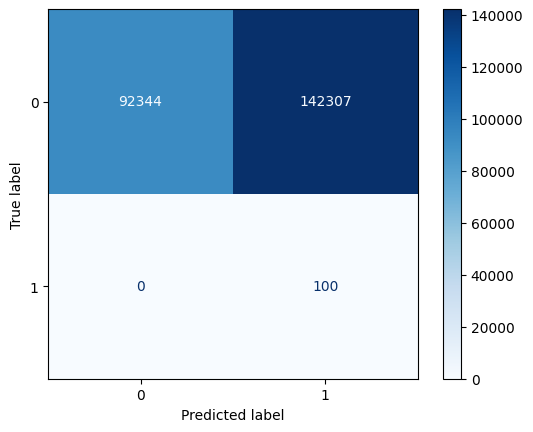

In [48]:
confusion_matrix = confusion_matrix(y_test, y_pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot(cmap="Blues")

plt.show()



### Random Forest Classifier

In [49]:
"""
# Forcer l'exécution sur CPU
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
# Nombre d'arbres de ta forêt
n_estimators = 300

# Créer un modèle en mode "warm_start" (permet d’ajouter les arbres un par un)
with tf.device("/CPU:0"):
    rf = RandomForestClassifier(
        n_estimators=1,  # on commence avec 1 arbre
        warm_start=True,
        random_state=42
    )

    # Entraînement incrémental avec tqdm
    for i in tqdm(range(1, n_estimators + 1), desc="Entraînement RF"):
        rf.n_estimators = i
        rf.fit(X_train_df, y_train)
"""

'\n# Forcer l\'exécution sur CPU\nfrom sklearn.ensemble import RandomForestClassifier\nfrom tqdm import tqdm\n# Nombre d\'arbres de ta forêt\nn_estimators = 300\n\n# Créer un modèle en mode "warm_start" (permet d’ajouter les arbres un par un)\nwith tf.device("/CPU:0"):\n    rf = RandomForestClassifier(\n        n_estimators=1,  # on commence avec 1 arbre\n        warm_start=True,\n        random_state=42\n    )\n\n    # Entraînement incrémental avec tqdm\n    for i in tqdm(range(1, n_estimators + 1), desc="Entraînement RF"):\n        rf.n_estimators = i\n        rf.fit(X_train_df, y_train)\n'

In [50]:
"""
# Importance des features
importance_rf = rf.feature_importances_

# Afficher les résultats
feature_importance_rf = pd.DataFrame({
    'Feature': X_train_df.columns,
    'Importance': importance_rf
}).sort_values(by='Importance', ascending=False)

feature_importance_rf
"""

"\n# Importance des features\nimportance_rf = rf.feature_importances_\n\n# Afficher les résultats\nfeature_importance_rf = pd.DataFrame({\n    'Feature': X_train_df.columns,\n    'Importance': importance_rf\n}).sort_values(by='Importance', ascending=False)\n\nfeature_importance_rf\n"

In [51]:
"""
# Visualiser l'importance des features
plt.figure(figsize=(20, 20))
plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='skyblue')
plt.xlabel('Importance des Features')
plt.title('Importance des Features dans le Modèle Random Forest')
plt.show()
"""

"\n# Visualiser l'importance des features\nplt.figure(figsize=(20, 20))\nplt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='skyblue')\nplt.xlabel('Importance des Features')\nplt.title('Importance des Features dans le Modèle Random Forest')\nplt.show()\n"

### PCA

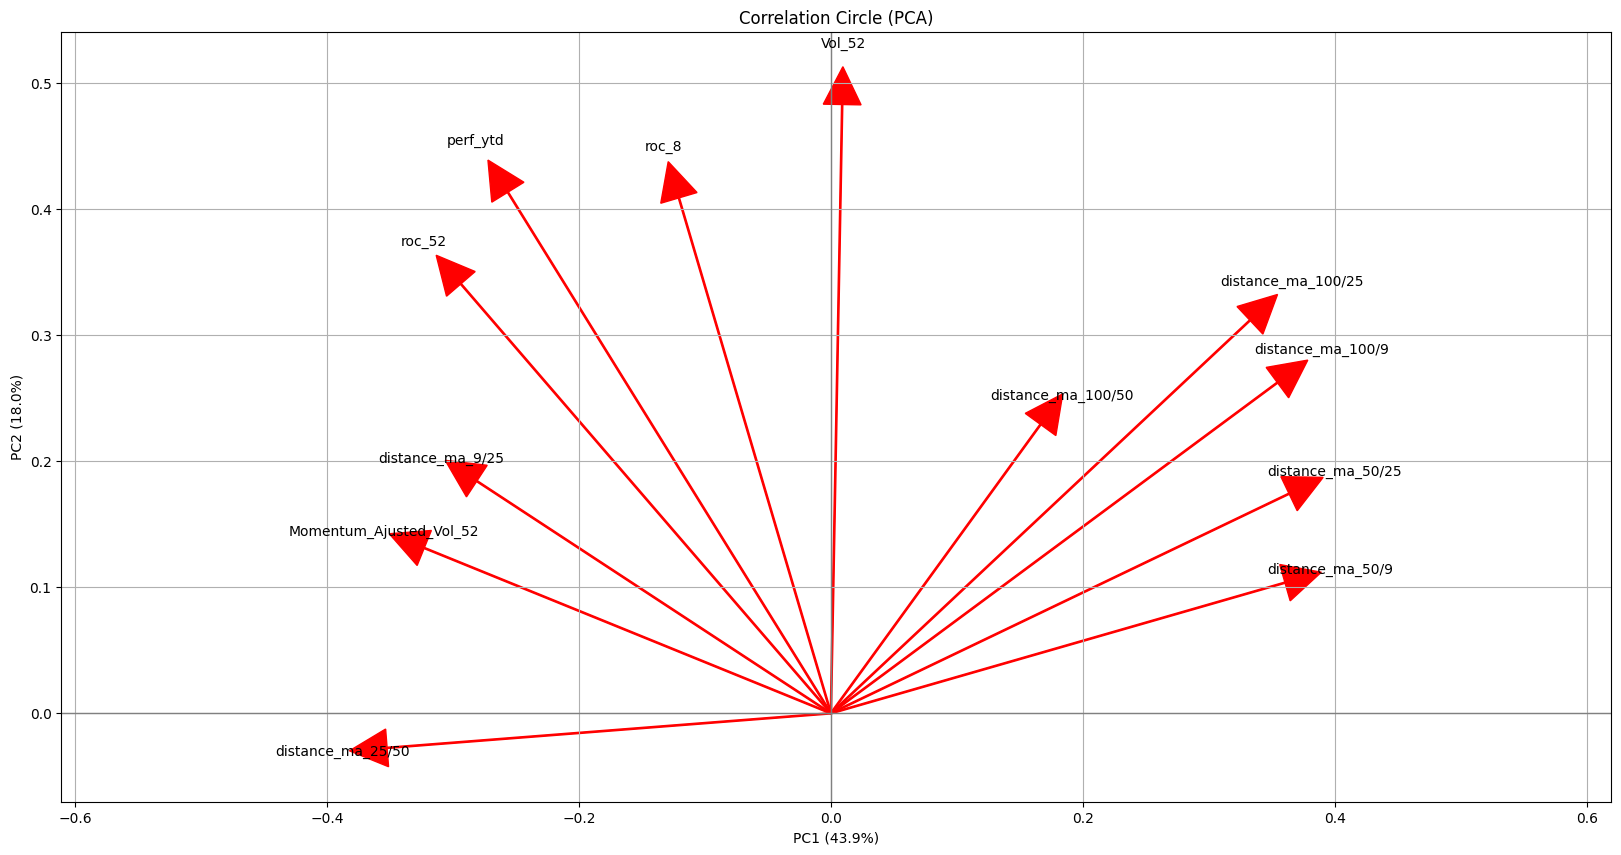

In [52]:

from sklearn.decomposition import PCA

#scaler = StandardScaler()
#X_res = scaler.fit_transform(X_res)

# Apply PCA
pca = PCA(n_components=len(feature_cols))
X_pca = pca.fit_transform(X_train_scale)

# Get the components (loadings)
pcs = pca.components_

# Get the feature names
features =feature_cols

# Correlation circle
plt.figure(figsize=(20, 10))
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)

# Draw unit circle
circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Plot arrows for each feature
for i, feature in enumerate(features):
    plt.arrow(0, 0, pcs[0, i], pcs[1, i], head_width=0.03, head_length=0.03, color='r')
    plt.text(pcs[0, i]*1.1, pcs[1, i]*1.1, feature, color='black', ha='center', va='center')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Correlation Circle (PCA)")
plt.grid()
plt.axis('equal')
plt.show()

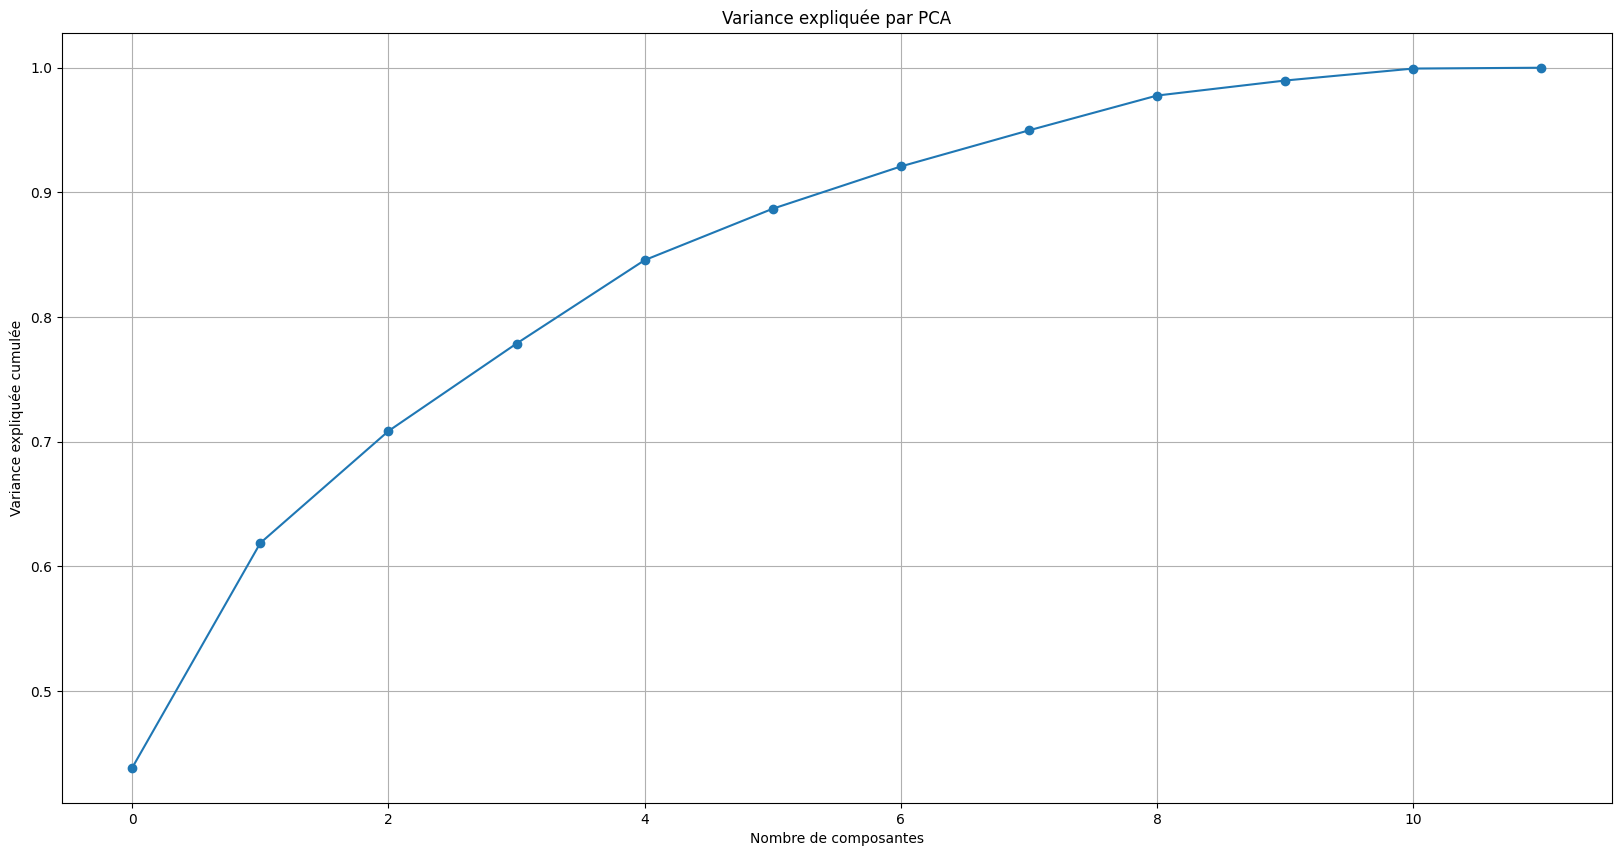

In [53]:

pca = PCA()
pca.fit(X_train_scale)  # X doit être centré-réduit !

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(20, 10))
plt.plot(cumulative_var, marker='o')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée par PCA")
plt.grid()
plt.show()


### Courbe ROC - AUC

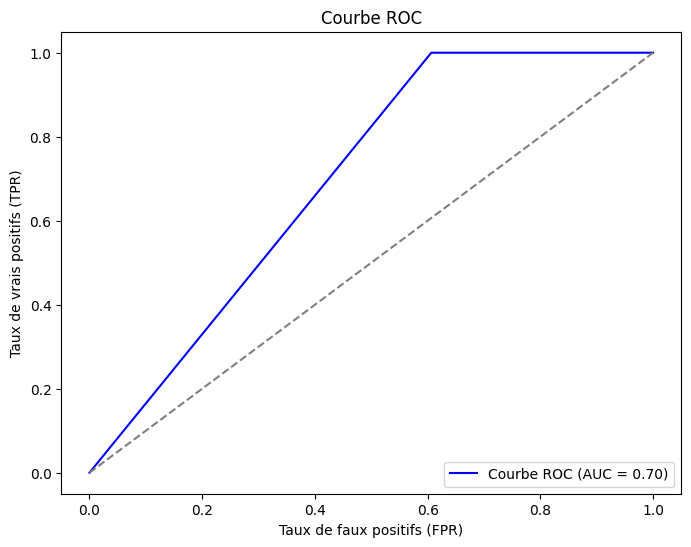

In [54]:
# Calcul des valeurs pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Calcul de l'AUC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne de référence (modèle aléatoire)
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

# Total Return Model Past Data

### Initialisation

In [55]:
def Calculate_Alpha_Jensen(portfolio_returns: pd.Series,
                          benchmark_returns: pd.Series,
                          risk_free_rate: float = 0.2
                         ) -> float:

    # 2) Estimation de beta
    cov_pm = np.cov(portfolio_returns, benchmark_returns, ddof=0)[0, 0]
    var_m  = np.var(benchmark_returns, ddof=0)
    beta   = cov_pm / var_m

    # 3) Rendement moyen
    mean_port = np.mean(portfolio_returns)
    mean_bench = np.mean(benchmark_returns)

    # 4) Calcul de l'alpha
    expected_port = risk_free_rate + beta * (mean_bench - risk_free_rate)
    alpha = mean_port - expected_port

    return alpha

In [56]:
def Calculate_CAGR(portfolio_returns, annual_returns):

    # Paramètres
    V_fin = portfolio_returns.iloc[-1]
    V_debut = initiale_capital
    t = annual_returns

    # Calculer du CAGR
    CAGR = (((V_fin / V_debut) ** (1 / t)) -1) * 100

    return CAGR

In [57]:
def Calculate_Volatility(returns, periods_per_year = 12):

    vol = returns.std(ddof=1)
    vol *= np.sqrt(periods_per_year)

    return vol

In [58]:
def Calculate_Sharpe_Ratio(returns, vol, risk_free_rate=0.02, periods_per_year=12):

    returns = Calculate_CAGR(returns, len(returns))
    excess_returns = returns - (risk_free_rate / periods_per_year)
    mean_exc = excess_returns.mean() * periods_per_year

    return mean_exc / Calculate_Volatility(vol)

In [59]:
def Calculate_Total_Returns(portfolio_returns):

    Value_start = initiale_capital
    Value_final = portfolio_returns.iloc[-1]

    Total_Returns = (Value_final - Value_start) / Value_start

    return Total_Returns

In [60]:
def Calculate_Max_Drawdown(annual_returns):

    maxdrawdown = annual_returns.min()

    return maxdrawdown

In [61]:
daily_data = pd.DataFrame()
data_SP500 = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_SP500.parquet')
data_NDX = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_NASDAQ.parquet')
data_MP = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_MP.parquet')
data_Crypto = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_Crypto.parquet')
daily_data = pd.concat([data_SP500, data_NDX, data_MP, data_Crypto], ignore_index=True)
daily_data = daily_data.drop_duplicates(subset=['Ticker', 'Date'])

daily_data = daily_data.drop(columns=['Adj Close'])
# trier la data pour préparer la fusion
daily_data = daily_data.sort_values(by=['Date'], ascending=[True])

#Date au format Date
daily_data['Date'] = pd.to_datetime(daily_data['Date'])

# Définir la colonne 'Date' comme index
daily_data.set_index('Date', inplace=True)
daily_data

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
1976-07-01,0.359528,0.362539,0.359528,0.359528,7.290000e+05,PEP
1976-07-01,2.178480,2.178480,2.178480,2.178480,0.000000e+00,GWW
1976-07-01,1.503224,1.503224,1.490321,1.490321,2.880000e+04,MMC
1976-07-01,0.049228,0.049228,0.049228,0.049228,2.880000e+04,SYY
1976-07-01,1.821361,1.868670,1.821361,1.862756,1.600000e+04,CMI
...,...,...,...,...,...,...
2025-10-07,61.669998,62.040001,61.270000,61.730000,4.038300e+04,CL=F
2025-10-07,48.375000,48.549999,47.520000,48.404999,3.330600e+04,SI=F
2025-10-07,3986.600098,4000.100098,3963.399902,3983.000000,1.227000e+05,GC=F


In [62]:
weekly_data = daily_data.groupby("Ticker").resample('W').agg({
    'Open': 'first',   # Premier prix d'ouverture du mois
    'High': 'max',     # Plus haut du mois
    'Low': 'min',      # Plus bas du mois
    'Close': 'last',   # Dernier prix de clôture du mois
    'Volume': 'sum',   # Somme du volume sur le mois
}).reset_index()

In [63]:
# Calculer le rendement pour chaque Ticker avec un décalage d'un mois
weekly_data['Return'] = (weekly_data['Close'] / weekly_data['Open']) -1

# Paramètres
liste_ma = [9, 20, 25, 50, 100]

# Calcul des moyennes mobiles pour chaque fenêtre
for window in liste_ma:
    # Calcul de la moyenne mobile pour chaque 'Ticker'
    ma_column = f'ma_{window}'
    weekly_data[ma_column] = weekly_data.groupby('Ticker')['Close'].transform(lambda s: s.rolling(window, min_periods=1).mean())

liste_ma_1 = [9, 25, 50, 100]
liste_ma_2 = [9, 25, 50, 100]

for window in liste_ma_1:
    for window_2 in liste_ma_2:

        # Calcul de la moyenne mobile pour chaque 'Ticker'
        ma_column_1 = f'ma_{window}'
        ma_column_2 = f'ma_{window_2}'
        distance_ma_column = f'distance_ma_{window_2}/{window}'

        if ma_column_1 != ma_column_2:
            # Calcul du pourcentage d'écart entre le prix et la moyenne mobile
            weekly_data[distance_ma_column] = weekly_data[ma_column_2] / weekly_data[ma_column_1]


list_window = [4, 8, 12, 26, 52] # Liste de valeurs de top_n pour la sélection des meilleurs

# Calcul des performances pour chaque fenêtre
for window in list_window:

    # Nom dynamique de la colonne pour la performance
    roc_column = f'roc_{window}'

    # Calcul de la performance pour chaque 'Ticker' sur la fenêtre spécifiée
    weekly_data[roc_column] = weekly_data.groupby('Ticker')['Close'].pct_change(window)

liste_ma = [9, 25]
for window in liste_ma:

    # Calcul de la moyenne mobile pour chaque 'Ticker'
    distance_price_column = f'distance_price_{window}'
    ma_column = f'ma_{window}'

    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile
    weekly_data[distance_price_column] = weekly_data['Close'] / weekly_data[ma_column]

weekly_data['Year'] = weekly_data['Date'].dt.year

# Close d’ancrage (première observation de l'année par Ticker)
anchor_close = weekly_data.groupby(['Ticker','Year'])['Close'].transform('first')

# Perf YTD (depuis le début d’année)
weekly_data['perf_ytd'] = weekly_data['Close'] / anchor_close - 1

list_window = [4, 8, 12, 26, 52] # Liste de valeurs de top_n pour la sélection des meilleurs

# Calcul des performances pour chaque fenêtre
for window in list_window:

    # Nom dynamique de la colonne pour la performance
    MAV_column = f'Momentum_Ajusted_Vol_{window}'
    Perf_column = f'Perf_{window}'
    Vol_column = f'Vol_{window}'

    # Calcul de la performance pour chaque 'Ticker' sur la fenêtre spécifiée
    weekly_data[Perf_column] = weekly_data.groupby('Ticker')['Close'].pct_change(window)
    weekly_data[Vol_column] = weekly_data.groupby('Ticker')['Return'].rolling(window=window).std().reset_index(level=0, drop=True)
    weekly_data[MAV_column] = weekly_data[Perf_column] / weekly_data[Vol_column]

period = 25

# Variation quotidienne
weekly_data['delta'] = weekly_data.groupby('Ticker')['Close'].diff()

# Gains et pertes
weekly_data['gains'] = weekly_data['delta'].clip(lower=0)
weekly_data['losses'] = -weekly_data['delta'].clip(upper=0)

# Moyenne mobile simple sur 'period' jours
weekly_data['avg_gain'] = (
    weekly_data.groupby('Ticker')['gains']
    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())
)
weekly_data['avg_losses'] = (
    weekly_data.groupby('Ticker')['losses']
    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())
)

# RS et RSI
weekly_data['rs'] = weekly_data['avg_gain'] / weekly_data['avg_losses']
weekly_data['rsi'] = 100 - (100 / (1 + weekly_data['rs']))

weekly_data = weekly_data.dropna()

/var/folders/6k/82j2nnl13hj9ld7nmzpdt6fh0000gn/T/ipykernel_1497/2063603485.py:38: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_data[roc_column] = weekly_data.groupby('Ticker')['Close'].pct_change(window)
/var/folders/6k/82j2nnl13hj9ld7nmzpdt6fh0000gn/T/ipykernel_1497/2063603485.py:38: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_data[roc_column] = weekly_data.groupby('Ticker')['Close'].pct_change(window)
/var/folders/6k/82j2nnl13hj9ld7nmzpdt6fh0000gn/T/ipykernel_1497/2063603485.py:38: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is 

In [64]:
start_date = "2023-01-01"
daily_data = daily_data.reset_index()

daily_data = daily_data[daily_data['Date'] >= start_date]
weekly_data = weekly_data[weekly_data['Date'] >= start_date]

weekly_data = weekly_data.replace([np.inf, -np.inf], 0)
#weekly_data = weekly_data.drop(columns=['Close', 'Open', 'High', 'Low', 'Volume'])
# Remplacer les valeurs NaN par 0
weekly_data = weekly_data.dropna()

weekly_data

Price,Ticker,Date,Open,High,Low,Close,Volume,Return,ma_9,ma_20,...,Perf_52,Vol_52,Momentum_Ajusted_Vol_52,delta,gains,losses,avg_gain,avg_losses,rs,rsi
1206,A,2023-01-01,146.293955,148.911432,144.401934,146.924484,3218000.0,0.004310,146.456612,135.914009,...,-0.055227,0.038785,-1.423941,0.630508,0.630508,-0.000000,2.812483,1.731191,1.624595,61.898878
1207,A,2023-01-08,149.192433,151.823620,140.405427,144.980560,6821300.0,-0.028231,147.743044,136.429072,...,0.024055,0.036933,0.651316,-1.943924,0.000000,1.943924,2.812483,1.664893,1.689287,62.815425
1208,A,2023-01-15,146.963795,155.711495,144.519139,154.062103,5808000.0,0.048300,148.706380,137.777431,...,0.091737,0.037442,2.450088,9.081543,9.081543,-0.000000,2.932653,1.664893,1.761466,63.787345
1209,A,2023-01-22,153.826435,155.279515,149.369176,153.080322,5114000.0,-0.004850,149.791550,139.167714,...,0.141342,0.037063,3.813527,-0.981781,0.000000,0.981781,2.577996,1.704165,1.512762,60.203157
1210,A,2023-01-29,153.158879,156.683493,150.046603,152.854507,4255100.0,-0.001987,149.678507,140.075985,...,0.143400,0.037076,3.867760,-0.225815,0.000000,0.225815,2.577996,1.694016,1.521825,60.346181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811667,ZTS,2025-09-14,152.500000,152.970001,146.490005,148.199997,14305100.0,-0.028197,151.566667,156.556070,...,-0.215014,0.028891,-7.442213,-5.120010,0.000000,5.120010,1.529783,2.079391,0.735688,42.385958
811668,ZTS,2025-09-21,148.080002,149.750000,145.149994,145.880005,15159000.0,-0.014857,151.264445,156.004305,...,-0.233520,0.028920,-8.074670,-2.319992,0.000000,2.319992,1.526604,2.172191,0.702795,41.273007
811669,ZTS,2025-09-28,146.550003,146.710007,139.339996,143.500000,15582400.0,-0.020812,150.306668,155.242344,...,-0.254423,0.028938,-8.791912,-2.380005,0.000000,2.380005,1.526604,1.815234,0.840996,45.681571
811670,ZTS,2025-10-05,143.860001,148.789993,142.399994,146.419998,16115900.0,0.017795,150.200000,154.438512,...,-0.220116,0.028949,-7.603568,2.919998,2.919998,-0.000000,1.643404,1.724246,0.953114,48.799723


In [65]:

# 1) Télécharger les cours mensuels ajustés du S&P 500
ndx = yf.download(
    "^GSPC",
    start="1976-07-01",
    end="2025-07-17",
    interval="1wk",
    auto_adjust=True,
    actions=False
)[["Open", "Close"]]

ndx.columns = ndx.columns.droplevel(level=1)

ndx.columns = ['ndx_Open', 'ndx_Close']

# 2) Convertir l’index en période mensuelle, puis au TIMESTAMP de fin de mois
ndx.index = pd.to_datetime(ndx.index)

# 3) Normaliser pour que le S&P 500 commence à la même valeur que le capital initial
ndx['Return'] = (ndx['ndx_Close'].pct_change()).fillna(0)

# Calcul des moyennes mobiles pour chaque fenêtre
ndx['Slow_ma'] = ndx['ndx_Close'].rolling(window=50, min_periods=1).mean()
ndx['Fast_ma'] = ndx['ndx_Close'].rolling(window=25, min_periods=1).mean()

crisis = []
for i in range(0, len(ndx)):
    if ndx['Slow_ma'].iloc[i] < ndx['ndx_Close'].iloc[i] and ndx['Slow_ma'].iloc[i] < ndx['ndx_Open'].iloc[i] and ndx['Slow_ma'].iloc[i] < ndx['Fast_ma'].iloc[i]:
        crisis.append(0)
    elif ndx['Fast_ma'].iloc[i] < ndx['ndx_Close'].iloc[i] and ndx['Fast_ma'].iloc[i] < ndx['ndx_Open'].iloc[i] and ndx['Slow_ma'].iloc[i] > ndx['Fast_ma'].iloc[i]:
        crisis.append(0)
    else:
        crisis.append(0)

ndx['Crisis'] = crisis

ndx = ndx.fillna(0)
ndx = ndx.drop(columns=['ndx_Open', 'ndx_Close','Return', 'Slow_ma', 'Fast_ma'])

weekly_data = pd.merge_asof(
    weekly_data.sort_values('Date'),
    ndx.sort_values('Date'),
    on='Date',
    direction='backward'
)

#data = data[data['Crisis'] == 0]


[*********************100%***********************]  1 of 1 completed


In [66]:
#data = data.drop(columns=['distance_ma_25/9', 'distance_ma_50/9', 'distance_ma_100/9', 'distance_ma_25/50', 'distance_ma_50/100', 'distance_ma_25/100'])

In [67]:
feature_cols

['distance_ma_50/9',
 'distance_ma_100/9',
 'distance_ma_9/25',
 'distance_ma_50/25',
 'distance_ma_100/25',
 'distance_ma_25/50',
 'distance_ma_100/50',
 'roc_8',
 'roc_52',
 'Vol_52',
 'Momentum_Ajusted_Vol_52',
 'perf_ytd']

In [68]:
X = weekly_data[[
'distance_ma_50/9',
 'distance_ma_100/9',
 'distance_ma_9/25',
 'distance_ma_50/25',
 'distance_ma_100/25',
 'distance_ma_25/50',
 'distance_ma_100/50',
 'roc_8',
 'roc_52',
 'Vol_52',
 'Momentum_Ajusted_Vol_52',
 'perf_ytd']]

X_scale_test = scaler.fit_transform(X)
weekly_data['Proba'] = best_model.predict(X_scale_test).ravel()


2381/2381 ━━━━━━━━━━━━━━━━━━━━ 1s 293us/step


In [69]:
weekly_data['Prediction'] = (weekly_data['Proba'] > 0.8).astype(int)
weekly_data['Prediction'].value_counts()

Prediction
0    67390
1     8785
Name: count, dtype: int64

### Backtest

In [70]:
daily_data['Return'] = daily_data.groupby('Ticker')['Close'].pct_change()
daily_data = daily_data[['Date', 'Close', 'Open', 'Ticker', 'Return']]
weekly_data = weekly_data.drop(columns=['Close', 'Open', 'Return'])


In [71]:
daily_data

Price,Date,Close,Open,Ticker,Return
3554231,2023-01-01,1200.964844,1196.713623,ETH-USD,NaN
3554232,2023-01-01,244.136978,246.332901,BNB-USD,NaN
3554233,2023-01-01,9.982173,9.961036,SOL-USD,NaN
3554234,2023-01-01,0.070225,0.070287,DOGE-USD,NaN
3554235,2023-01-01,16625.080078,16547.914062,BTC-USD,NaN
...,...,...,...,...,...
3920807,2025-10-07,61.669998,61.730000,CL=F,-0.000324
3920808,2025-10-07,48.375000,48.404999,SI=F,0.006094
3920809,2025-10-07,3986.600098,3983.000000,GC=F,0.009649
3920810,2025-10-07,5.073000,5.042000,HG=F,0.017245


In [72]:
data = pd.merge_asof(daily_data, weekly_data, on='Date', by='Ticker', direction='backward')
data['weekday'] = data['Date'].dt.dayofweek
data = data[data['weekday'] < 5]

In [73]:
import numpy as np
import pandas as pd

def backtest(
    data: pd.DataFrame,
    initial_capital: float = 1000,
    save_month: float = 0,
    fee_per_trade: float = 0,
    moving_average_buy: int = 9,
    moving_average_sell: int = 25,
    proba_column: str = "Proba",
    max_positions: int = 10,
    leverage: float = 1.0,
    weight: float = 1.0,
):
    """
    Backtest vectorisé avec pandas :
      - data : DataFrame (Date, Ticker, Open, Close, Prediction, Return, Crisis, ma_xx, Proba, ...)
      - stop_loss : seuil de perte à partir du prix d’entrée (optionnel)
      - retourne aussi la liste des tickers détenus par jour
    """

    ma_buy  = f"ma_{moving_average_buy}"
    ma_sell = f"ma_{moving_average_sell}"

    required = ["Date","Ticker","Open","Close","Prediction","Return",ma_buy,ma_sell,"Crisis", 'rsi']
    missing = [c for c in required if c not in data.columns]
    if (missing or max_positions >weight):
        raise ValueError(f"Colonnes manquantes: {missing}")

    df = data.sort_values(["Date", "Ticker"]).copy()

    # --- 1. Préparer signaux (vectorisé) ---
    df["BuySignal"] = (
        (df[ma_buy] < df["Open"]) &
        (df[ma_buy] < df["Close"]) &
        (df["Prediction"] == 1) &
        (df['rsi'] > 50)
    )

    df["SellSignal"] = (
        (df[ma_sell] > df["Open"]) &
        (df[ma_sell] > df["Close"]) |
        (df["rsi"] < 45)
    )

    # Poids (score de tri pour sélectionner max_positions)
    if proba_column in df.columns:
        df["Score"] = df[proba_column].fillna(0.0)
    else:
        df["Score"] = (df["Close"] / df[ma_buy] - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # Décalage Return pour obtenir rendement t+1 directement
    df["NextReturn"] = df.groupby("Ticker")["Return"].shift(-1)

    # --- 2. Boucle sur dates (plus légère) ---
    unique_dates = df["Date"].drop_duplicates().sort_values().to_numpy()
    capital = initial_capital

    portfolio_values, returns, n_positions, fees_hist, mean_return_history = [], [], [], [], []
    tickers_history = {}  # 🔥 tickers détenus par jour

    prev_holdings = set()

    for date in unique_dates:
        day = df.loc[df["Date"] == date]

        # Ajouter capital mensuel
        capital += save_month

        # Gestion des signaux
        buy_set  = set(day.loc[day["BuySignal"], "Ticker"])
        sell_set = set(day.loc[day["SellSignal"], "Ticker"])

        # Portefeuille courant
        held_after_sell = prev_holdings - sell_set
        new_buys = buy_set - prev_holdings

        # Tri par Score
        scores = day.set_index("Ticker")["Score"].to_dict()
        held_sorted = sorted(list(held_after_sell), key=lambda t: scores.get(t, 0.0), reverse=True)

        if len(held_sorted) >= max_positions:
            current_portfolio = set(held_sorted[:max_positions])
        else:
            remaining = max_positions - len(held_sorted)
            new_sorted = sorted(list(new_buys), key=lambda t: scores.get(t, 0.0), reverse=True)
            add_these = new_sorted[:remaining]
            current_portfolio = set(held_sorted + add_these)

        # Frais
        opened = current_portfolio - prev_holdings
        closed = prev_holdings - current_portfolio
        trades = len(opened) + len(closed)
        fees = trades * fee_per_trade
        capital -= fees

        # Calcul rendement t+1
        r = day.loc[day["Ticker"].isin(current_portfolio), "NextReturn"].dropna().to_numpy()
        l = day.loc[day["Ticker"].isin(current_portfolio), ("NextReturn", 'Ticker')]
        if r.size > 0:
            mean_return = np.mean(r) * leverage
            invested_fraction = len(r) / weight  # part du capital investi
            capital *= 1 + invested_fraction * mean_return
        else:
            mean_return = 0.0
            capital *= (1 + mean_return)

        # Historique
        portfolio_values.append(capital)
        returns.append(mean_return)
        n_positions.append(len(current_portfolio))
        fees_hist.append(fees)
        tickers_history[date] = l # 🔥 tickers détenus
        mean_return_history.append(mean_return)

        prev_holdings = current_portfolio

    # --- Résultats ---
    portfolio_per_day = pd.DataFrame({
        "Date": unique_dates,
        "Capital": portfolio_values,
        "Return": np.array(returns) * 100.0,
        "Ticker_Count": n_positions,
        "Fees": fees_hist,
        "Return_Mean": mean_return_history,
    }).set_index("Date")

    monthly = portfolio_per_day.resample("ME").agg({
        "Capital": "last",
        "Ticker_Count": "mean",
        "Fees": "sum",
        "Return_Mean": "mean",
    })
    first_cap_m = portfolio_per_day["Capital"].resample("ME").first().ffill()
    last_cap_m  = portfolio_per_day["Capital"].resample("ME").last().ffill()
    monthly["Return"] = ((last_cap_m / first_cap_m - 1.0) * 100.0).fillna(0.0)

    annual = portfolio_per_day.resample("YE").agg({
        "Capital": "last",
        "Ticker_Count": "mean",
        "Fees": "sum",
        "Return_Mean": "mean"
    })
    first_cap_y = portfolio_per_day["Capital"].resample("YE").first().ffill()
    last_cap_y  = portfolio_per_day["Capital"].resample("YE").last().ffill()
    annual["Return"] = ((last_cap_y / first_cap_y - 1.0) * 100.0).fillna(0.0)

    return portfolio_per_day, monthly, annual, tickers_history

In [74]:
initiale_capital = 1000
portfolio_per_day, portfolio_per_month, portfolio_per_annual, list_ticker = backtest(data, initial_capital=initiale_capital, save_month=0, fee_per_trade=1, moving_average_buy=9, moving_average_sell=25, max_positions=10, leverage=1, weight=10)

In [75]:
worst = portfolio_per_month[portfolio_per_month['Return'] < 0]
worst = worst.sort_values(by=['Return'], ascending=True)
print(len(portfolio_per_month), len(worst), len(worst)/len(portfolio_per_month)*100)
worst.head(20)

34 14 41.17647058823529


,Capital,Ticker_Count,Fees,Return_Mean,Return
Date,,,,,
2025-02-28,3744.180482,10.000000,14,-0.010625,-18.358524
2024-04-30,2599.051692,10.000000,2,-0.007602,-14.459828
2024-07-31,2699.835410,9.956522,14,-0.006824,-13.034170
2024-12-31,3955.030273,10.000000,2,-0.005777,-8.819840
2023-03-31,1069.976919,10.000000,8,-0.000978,-5.244317
2023-09-30,1396.807003,10.000000,4,-0.002212,-5.234900
2023-02-28,1108.733500,10.000000,0,-0.001543,-4.909959
2025-03-31,3589.345511,10.000000,10,-0.001631,-4.522717
2023-04-30,1031.071472,10.000000,8,0.000118,-3.358359


In [76]:
worst_mean_return = portfolio_per_month[portfolio_per_month['Return_Mean'] < 0][['Ticker_Count', 'Fees', 'Return_Mean']]
worst_mean_return = worst_mean_return.sort_values(by=['Return_Mean'], ascending=True)
print(len(portfolio_per_month), len(worst_mean_return), len(worst_mean_return)/len(portfolio_per_month)*100)
worst_mean_return.describe()

34 12 35.294117647058826


,Ticker_Count,Fees,Return_Mean
count,12.000000,12.000000,12.000000
mean,9.996377,7.000000,-0.003637
std,0.012551,5.624621,0.003359
min,9.956522,0.000000,-0.010625
25%,10.000000,2.000000,-0.006039
50%,10.000000,6.000000,-0.002068
75%,10.000000,12.500000,-0.001402
max,10.000000,14.000000,-0.000100


In [77]:
best_mean_return = portfolio_per_month[portfolio_per_month['Return_Mean'] > 0]
best_mean_return = best_mean_return.sort_values(by=['Return_Mean'], ascending=False)
print(len(portfolio_per_month), len(best_mean_return), len(best_mean_return)/len(portfolio_per_month)*100)
best_mean_return.describe()

34 22 64.70588235294117


,Capital,Ticker_Count,Fees,Return_Mean,Return
count,22.000000,22.000000,22.000000,22.000000,22.000000
mean,2894.600945,9.764463,4.272727,0.005746,10.623531
std,1249.736144,0.790866,8.536654,0.004558,10.728171
min,1031.071472,6.727273,0.000000,0.000017,-3.358359
25%,1601.559850,10.000000,0.000000,0.002849,3.495133
50%,3111.965534,10.000000,2.000000,0.005281,9.549355
75%,4139.679964,10.000000,2.000000,0.007546,14.375932
max,4730.005660,10.000000,36.000000,0.017665,39.100893


In [78]:
portfolio_per_day['Ticker_Count'].describe()

count    722.000000
mean       9.840720
std        1.001166
min        0.000000
25%       10.000000
50%       10.000000
75%       10.000000
max       10.000000
Name: Ticker_Count, dtype: float64

In [79]:
portfolio_per_month.tail(20)

,Capital,Ticker_Count,Fees,Return_Mean,Return
Date,,,,,
2024-03-31,3101.008107,10.000000,0,0.004748,6.291829
2024-04-30,2599.051692,10.000000,2,-0.007602,-14.459828
2024-05-31,3122.922960,10.000000,0,0.007947,15.495591
2024-06-30,3129.090880,10.000000,2,0.000017,-1.261871
2024-07-31,2699.835410,9.956522,14,-0.006824,-13.034170
2024-08-31,2663.880411,10.000000,14,-0.000100,3.848417
2024-09-30,2995.985277,10.000000,2,0.005720,12.466959
2024-10-31,3194.180886,10.000000,2,0.002857,5.287076
2024-11-30,4259.752039,10.000000,0,0.014038,33.614441


In [80]:
portfolio_per_annual

,Capital,Ticker_Count,Fees,Return_Mean,Return
Date,,,,,
2023-12-31,1754.262580,9.838462,64,0.002954,75.426258
2024-12-31,3955.030273,9.996183,40,0.002999,125.814954
2025-12-31,4654.857037,9.640000,74,0.001685,17.177770


In [81]:
list_ticker

{np.datetime64('2023-01-02T00:00:00.000000000'): Empty DataFrame
 Columns: [NextReturn, Ticker]
 Index: [],
 np.datetime64('2023-01-03T00:00:00.000000000'):      NextReturn Ticker
 277    0.030193   FICO
 112    0.077251    PDD,
 np.datetime64('2023-01-04T00:00:00.000000000'):      NextReturn Ticker
 964   -0.019933   FICO
 619    0.047990    PDD,
 np.datetime64('2023-01-05T00:00:00.000000000'):       NextReturn Ticker
 1472    0.008444   FICO
 1141    0.005554    PDD,
 np.datetime64('2023-01-06T00:00:00.000000000'):       NextReturn Ticker
 2061   -0.013407   FICO
 1641   -0.004585    PDD
 1610    0.020918    SLB,
 np.datetime64('2023-01-09T00:00:00.000000000'):       NextReturn   Ticker
 2192    0.016825  BNB-USD
 2556    0.022175      CCL
 2327   -0.013488     FICO
 2161   -0.014971      PDD
 2292    0.010898     PYPL
 2338    0.028626      RCL
 2183    0.005751      SLB
 2531    0.023358     UBER
 2533    0.014046      XYZ
 2225    0.054452        Z,
 np.datetime64('2023-01-10T00:0

In [82]:
list_ticker.items()

dict_items([(np.datetime64('2023-01-02T00:00:00.000000000'), Empty DataFrame
Columns: [NextReturn, Ticker]
Index: []), (np.datetime64('2023-01-03T00:00:00.000000000'),      NextReturn Ticker
277    0.030193   FICO
112    0.077251    PDD), (np.datetime64('2023-01-04T00:00:00.000000000'),      NextReturn Ticker
964   -0.019933   FICO
619    0.047990    PDD), (np.datetime64('2023-01-05T00:00:00.000000000'),       NextReturn Ticker
1472    0.008444   FICO
1141    0.005554    PDD), (np.datetime64('2023-01-06T00:00:00.000000000'),       NextReturn Ticker
2061   -0.013407   FICO
1641   -0.004585    PDD
1610    0.020918    SLB), (np.datetime64('2023-01-09T00:00:00.000000000'),       NextReturn   Ticker
2192    0.016825  BNB-USD
2556    0.022175      CCL
2327   -0.013488     FICO
2161   -0.014971      PDD
2292    0.010898     PYPL
2338    0.028626      RCL
2183    0.005751      SLB
2531    0.023358     UBER
2533    0.014046      XYZ
2225    0.054452        Z), (np.datetime64('2023-01-10T00:00:0

In [83]:
# 1) Calculer le drawdown mensuel
#    drawdown = (Capital / pic_historique) - 1
portfolio_per_day['Peak'] = portfolio_per_day['Capital'].cummax()
portfolio_per_day['Drawdown'] = portfolio_per_day['Capital'] / portfolio_per_day['Peak'] - 1

# 2) Résultat : série mensuelle de drawdowns
#    Le drawdown est négatif (0 au pic, baisse ensuite)  [oai_citation:0‡reddit.com](https://www.reddit.com/r/learnpython/comments/bxyze5/getting_max_drawdown_with_python/?utm_source=chatgpt.com)

# 3) Calculer le max drawdown global
max_dd_global = portfolio_per_day['Drawdown'].min()

# 4) Calculer le drawdown maximal par année
#    On regroupe par année et on prend le minimum (le plus négatif) de Drawdown
mensuel_max_dd = (
    portfolio_per_day['Drawdown']
    .groupby(portfolio_per_day.index.year)
    .min()
    .rename('MaxDrawdown')
    .to_frame()
)

# Calcul du nombre d'actions sélectionnées chaque mois
monthly_counts = data.groupby('Date')['Prediction'].sum()
monthly_counts.index = pd.to_datetime(monthly_counts.index)

# Moyenne des sélections mensuelles
average_count = monthly_counts.mean()

# 1) Regrouper par année (resample('Y') pour Year-End)
annual_counts = monthly_counts.resample('YE').sum()

# 2) Calculer la moyenne annuelle des sélections
average_annual_count = annual_counts.mean()


In [84]:
data = data.sort_values('Date')
# 1) Télécharger les cours mensuels ajustés du S&P 500
ndx = yf.download(
    "^GSPC",
    start=data['Date'].iloc[0],
    end=data['Date'].iloc[-1],
    interval="1d",
    auto_adjust=True,
    actions=False
)["Close"]
# 2) Convertir l’index en période mensuelle, puis au TIMESTAMP de fin de mois
ndx.index = pd.to_datetime(ndx.index)

# 3) Normaliser pour que le S&P 500 commence à la même valeur que le capital initial
ndx_return = (ndx.pct_change())

# 4) Reindexer ndx_norm sur l’index de portfolio_per_month (remplit les mois manquants par propagation)
ndx_return = ndx_return.reindex(portfolio_per_day.index, method="ffill")

# 5) Fusionner dans df_bench
portfolio_per_day["S&P500_return"] = ndx_return
portfolio_per_day["S&P500_return"].fillna(0)

initial_cap_ndx = portfolio_per_day["Capital"].iloc[0]
portfolio_per_day["S&P500_capital"] = (1 + portfolio_per_day["S&P500_return"]).cumprod() * initial_cap_ndx
portfolio_per_day['S&P500_return'] = portfolio_per_day['S&P500_return'] * 100

# 1) Calculer le drawdown mensuel
#    drawdown = (Capital / pic_historique) - 1
portfolio_per_day['S&P500_Peak'] = portfolio_per_day['S&P500_capital'].cummax()
portfolio_per_day['S&P500_Drawdown'] = portfolio_per_day['S&P500_capital'] / portfolio_per_day['S&P500_Peak'] - 1

# 3) Calculer le max drawdown global
max_dd_global_ndx = portfolio_per_day['S&P500_Drawdown'].min()

# 4) Calculer le drawdown maximal par année
#    On regroupe par année et on prend le minimum (le plus négatif) de Drawdown
mensuel_max_dd_ndx = (
    portfolio_per_day['S&P500_Drawdown']
    .groupby(portfolio_per_day.index.year)
    .min()
    .rename('MaxDrawdown')
    .to_frame()
)

portfolio_per_month = portfolio_per_day.resample('ME').agg({
    'Capital': 'last',
    'Ticker_Count': 'mean',
    'Drawdown': 'min',
    'S&P500_capital': 'last',
    'S&P500_Drawdown': 'min'
})
first_capital_month = portfolio_per_day['Capital'].resample('ME').first().ffill()
last_capital_month = portfolio_per_day['Capital'].resample('ME').last().ffill()
first_capital_ndx_month = portfolio_per_day['S&P500_capital'].resample('ME').first().ffill()
last_capital_ndx_month = portfolio_per_day['S&P500_capital'].resample('ME').last().ffill()

portfolio_per_month['Return'] = ((last_capital_month / first_capital_month - 1) * 100).fillna(0)
portfolio_per_month['S&P500_return'] = ((last_capital_ndx_month / first_capital_ndx_month - 1) * 100).fillna(0)

portfolio_per_annual = portfolio_per_day.resample('YE').agg({
    'Capital': 'last',
    'Ticker_Count': 'mean',
    'Drawdown': 'min',
    'S&P500_capital': 'last',
    'S&P500_Drawdown': 'min'
})
first_capital_year = portfolio_per_day['Capital'].resample('YE').first().ffill()
first_capital_ndx_year = portfolio_per_day['S&P500_capital'].resample('YE').first().ffill()
last_capital_year = portfolio_per_day['Capital'].resample('YE').last().ffill()
last_capital_ndx_year = portfolio_per_day['S&P500_capital'].resample('YE').first().ffill()

portfolio_per_annual['Return'] = ((last_capital_year / first_capital_year - 1) * 100).fillna(0)
portfolio_per_annual['S&P500_return'] = ((last_capital_ndx_year / first_capital_ndx_year - 1) * 100).fillna(0)

[*********************100%***********************]  1 of 1 completed


In [85]:
comparaison_benchmark = portfolio_per_month[portfolio_per_month['Return'] < portfolio_per_month['S&P500_return']].sort_values(by=['Date'], ascending=True)
print(len(comparaison_benchmark)/len(portfolio_per_month))
comparaison_benchmark.head(10)

0.47058823529411764


,Capital,Ticker_Count,Drawdown,S&P500_capital,S&P500_Drawdown,Return,S&P500_return
Date,,,,,,,
2023-02-28,1108.733500,10.000000,-0.097385,1039.446048,-0.052804,-4.909959,-3.885383
2023-03-31,1069.976919,10.000000,-0.135040,1075.880309,-0.080069,-5.244317,3.996573
2023-04-30,1031.071472,10.000000,-0.143968,1095.540851,-0.028834,-3.358359,1.452135
2023-08-31,1470.407851,10.000000,-0.120586,1196.847899,-0.047778,-1.518397,-1.509152
2023-09-30,1396.807003,10.000000,-0.148431,1140.586604,-0.067061,-5.234900,-4.871937
2024-04-30,2599.051692,10.000000,-0.188206,1339.362595,-0.054644,-14.459828,-3.968139
2024-06-30,3129.090880,10.000000,-0.082093,1466.201110,-0.007137,-1.261871,3.612214
2024-07-31,2699.835410,9.956522,-0.182439,1490.339654,-0.047286,-13.034170,1.375097
2024-12-31,3955.030273,10.000000,-0.122975,1614.878575,-0.036647,-8.819840,-1.663107


### Visualisation

In [86]:
CAGR_Portfolio = Calculate_CAGR(portfolio_per_annual['Capital'], len(portfolio_per_annual)).round(2)
CAGR_ndx = Calculate_CAGR(portfolio_per_annual['S&P500_capital'], len(portfolio_per_annual)).round(2)
print(f'CAGR_Portfolio:{CAGR_Portfolio}')
print(f'CAGR_ndx:{CAGR_ndx}')

CAGR_Portfolio:66.97
CAGR_ndx:23.06


In [87]:
Alpha_Portfolio = Calculate_Alpha_Jensen(portfolio_per_day['Return'], portfolio_per_day['S&P500_return'])
print(f'Alpha_Portfolio:{Alpha_Portfolio}')

Alpha_Portfolio:0.6027291390953113


In [88]:
Sharpe_Portfolio = Calculate_Sharpe_Ratio(portfolio_per_month['Capital'], portfolio_per_month['Return']).round(2)
Sharpe_ndx = Calculate_Sharpe_Ratio(portfolio_per_month['S&P500_capital'], portfolio_per_month['S&P500_return']).round(2)
print(f'Sharpe_Portfolio:{Sharpe_Portfolio}')
print(f'Sharpe_ndx:{Sharpe_ndx}')

Sharpe_Portfolio:1.29
Sharpe_ndx:1.96


In [89]:
Total_Returns_Portfolio = Calculate_Total_Returns(portfolio_per_month['Capital']).round(2)
Total_Returns_ndx = Calculate_Total_Returns(portfolio_per_month['S&P500_capital']).round(2)
print(f'Total_Return_Portfolio:{Total_Returns_Portfolio}')
print(f'Total_Return_ndx:{Total_Returns_ndx}')

Total_Return_Portfolio:3.65
Total_Return_ndx:0.86


In [90]:
Max_Drawdown_Portfolio = Calculate_Max_Drawdown(portfolio_per_day['Return'])
Max_Drawdown_ndx = Calculate_Max_Drawdown(portfolio_per_day['S&P500_return'])
print(f'Max_Drawdown_Portfolio:{Max_Drawdown_Portfolio}')
print(f'Max_Drawdown_ndx:{Max_Drawdown_ndx}')

Max_Drawdown_Portfolio:-6.599381844205199
Max_Drawdown_ndx:-5.974960534553109


In [91]:
Volatility_Portfolio = Calculate_Volatility(portfolio_per_month['Return']).round(2)
Volatility_ndx = Calculate_Volatility(portfolio_per_month['S&P500_return']).round(2)
print(f'Volatility_Portfolio:{Volatility_Portfolio}')
print(f'Volatility_ndx:{Volatility_ndx}')

Volatility_Portfolio:42.87
Volatility_ndx:11.27


In [92]:
# 6) Tracer l’évolution du capital vs benchmark (échelle log)
fig = px.line(
    portfolio_per_month.reset_index(),
    x="Date",
    y=["Capital", "S&P500_capital"],
    title="Évolution du capital vs S&P 500 (benchmark)",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)

fig.update_yaxes(type="log")  # axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.bar(
    portfolio_per_month.reset_index(),
    x="Date",
    y=["Return", "S&P500_return"],
    barmode="group",
    title="Return evolution vs S&P500 (benchmark)",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
# axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.area(
    portfolio_per_month.reset_index(),
    x='Date',
    y=["Drawdown", "S&P500_Drawdown"],
    title="Drawdown mensuel",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
fig.update_layout(
    xaxis_tickformat='%Y-%m',
    yaxis_tickformat='%.0%',
    yaxis_title="Drawdown",
)
fig.show()

fig = px.bar(
    portfolio_per_month.reset_index(),
    x="Date",
    y="Ticker_Count",
    title="Counts tickers by month",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
# axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.line(
    portfolio_per_annual.reset_index(),
    x="Date",
    y=["Capital", "S&P500_capital"],
    title="Évolution du capital vs S&P500 (benchmark)",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)

fig.update_yaxes(type="log")  # axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.bar(
    portfolio_per_annual.reset_index(),
    x="Date",
    y=["Return", "S&P500_return"],
    barmode="group",
    title="Return evolution vs S&P500 (benchmark)",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
# axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.area(
    portfolio_per_annual.reset_index(),
    x='Date',
    y=["Drawdown", "S&P500_Drawdown"],
    title="Drawdown annuel",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
fig.update_layout(
    xaxis_tickformat='%Y-%m',
    yaxis_tickformat='%.0%',
    yaxis_title="Drawdown",
)
fig.show()